In [1]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import trange
import torch.nn.functional as F
import matplotlib.pyplot as plt

from edunets import functional, losses
from edunets.tensor import Tensor

(<matplotlib.image.AxesImage at 0x7f32771f17c0>, 5)

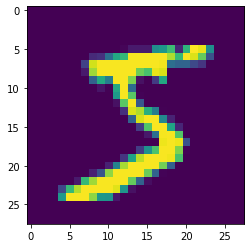

In [2]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]

# In Pytorch

In [3]:
# Pytorch model and training tensors

class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()
        self.l1 = nn.Linear(28*28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x) # first layer
        x = F.relu(x)  # activation function
        x = self.l2(x) # secound layer: down to 10 outputs
        #x = self.sm(x) # softmax
        return x

model = TorchNet()
dummy_tensor = torch.Tensor([X_train[0].reshape(28*28)])
print("Does dummy_tensor require a gradient ?", dummy_tensor.requires_grad)
dummy_output = model(dummy_tensor)
print("Does dummy_output require a gradient ?", dummy_output.requires_grad)


Does dummy_tensor require a gradient ? False
Does dummy_output require a gradient ? True


In [4]:
# Testing two different losses

nn_NLLLoss = nn.NLLLoss(reduction="mean")
nn_MSELoss = nn.MSELoss(reduction="mean")
nn_CrossEntropyLoss = nn.CrossEntropyLoss(reduction="mean")

def NLLLoss(Y_pred, Y):
    """
    works well (with a final LogSoftmax layer !)
    """
    loss = nn_NLLLoss(Y_pred, Y)
    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()

    return loss, accuracy

def MSELoss(Y_pred, Y):
    """
    doesn't work at all
    """
    Y_one_hot = torch.zeros(Y.shape[0], 10)
    slice = [(i, y) for i, y in enumerate(Y)] if Y.shape[0] > 1 else (0,Y[0])
    Y_one_hot[slice] = 1.0

    loss = nn_MSELoss(Y_pred, Y_one_hot)

    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()
    
    return loss, accuracy

def CrossEntropyLoss(Y_pred, Y):
    """
    works well 
    """
    loss = nn_CrossEntropyLoss(Y_pred, Y)
    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()

    return loss, accuracy

loss 0.20 accuracy 0.94:   9%|▉         | 94/1000 [00:00<00:01, 474.91it/s]

Y_pred: tensor([17., 23., -5., -5., 25., -3., -0., 23., -5.,  3.],
       grad_fn=<RoundBackward>)
Y: tensor(3)
Y_pred after argmax: tensor(4)
loss: tensor(28.3567, grad_fn=<NllLossBackward>)


loss 0.40 accuracy 0.91: 100%|██████████| 1000/1000 [00:02<00:00, 412.75it/s]


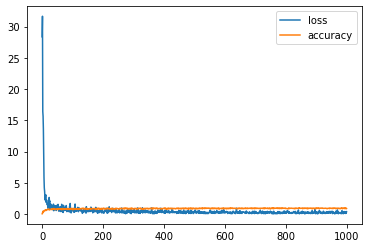

In [5]:
# Pytorch Training

model = TorchNet()

# Loss function defined above
loss_fn = CrossEntropyLoss

# Stocastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

# Training paramaters
epochs = 1000
batch_size = 64

losses, accuracies = [], []

# Training loop
for i in (t := trange(epochs)):
    # Get random slicing the size of the batch
    sample = np.random.randint(0, X_train.shape[0], size=(batch_size))

    # Define X and Y (flatten X so the image is one single dimention)
    # Conversion to float is important so the Linear layers accept X as a input
    X = torch.tensor(X_train[sample].reshape(-1, 28*28), dtype=torch.float)
    Y = torch.tensor(Y_train[sample], dtype=torch.long)

    Y_pred = model(X)

    # This prints shows the form of Y_pred, it is clear argmax needs to be applied
    # to compare Y_pred with Y
    if i == 0:
        print("Y_pred:", Y_pred[0].round())
        print("Y:", Y[0])
        print("Y_pred after argmax:", torch.argmax(Y_pred, dim=1)[0])
    
    loss, accuracy = loss_fn(Y_pred, Y)

    if i == 0:
        print("loss:", loss)

    # Backpropagation
    loss.backward()

    # Updating weights
    optimizer.step()

    # Reset weights for next epoch
    model.zero_grad()

    loss = loss.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.plot(losses, label="loss")
plt.plot(accuracies, label="accuracy")
plt.legend()
plt.show()


# In Edunets

max/min L1: tensor(-0.0357142, dtype=float32) tensor(0.03571314, dtype=float32)
max/min L2: tensor(-0.08831859, dtype=float32) tensor(0.08836837, dtype=float32)


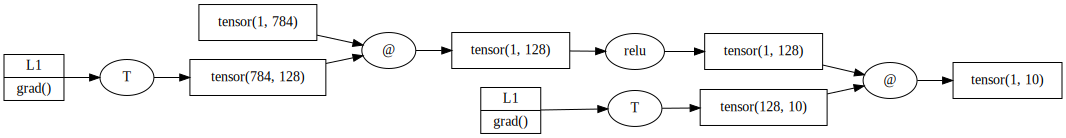

In [3]:
class EduNet1:
    def __init__(self):
        # https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073
        stdv1, stdv2 = 1./np.sqrt(28*28), 1./np.sqrt(128)
        self.l1 = Tensor.uniform(128, 28*28, low=-stdv1, high=stdv1, requires_grad=True, label="L1")
        self.l2 = Tensor.uniform(10, 128, low=-stdv2, high=stdv2, requires_grad=True, label="L1")

    def __call__(self, x):
        x = x @ self.l1.T
        x = x.relu()
        x = x @ self.l2.T
        return x

model = EduNet1()

print("max/min L1:", model.l1.min(), model.l1.max())
print("max/min L2:", model.l2.min(), model.l2.max())

dummy_tensor = Tensor([X_train[0].reshape(28*28)])
model(dummy_tensor).graph

In [4]:
# Stochastic gradient descent
class SGD:
    def __init__(self, params, lr=0.001):
        self.lr = lr
        self.params = params

    def step(self):
        for t in self.params:
            t.data = t.data - t.grad * self.lr

    def zero_grad(self):
        for param in self.params:
            param.zero_grad()

In [5]:
from edunets.losses import CrossEntropyLoss

model = EduNet1()

batch_size = 64
loss_fn = CrossEntropyLoss(reduction="mean")
optim = SGD([model.l1, model.l2], lr=0.001)
epochs = 1000
losses, accuracies = [], []

# Intresting to allow NaNs to see the effect of overflow of expontentials
#model.l1.keep_nans() # This will break the network though

loss 26.33 accuracy 25.00:   0%|          | 0/1000 [00:00<?, ?it/s]/home/goncalo/edunets/edunets/ops.py:34: RuntimeWarning: overflow encountered in exp
  return np.exp(self.a.data)
/home/goncalo/anaconda3/envs/pi_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
loss 11.46 accuracy 29.69:   1%|          | 9/1000 [00:00<00:22, 43.35it/s] 

Initial Loss: tensor(26.330824, dtype=float32)


loss 0.48 accuracy 89.06: 100%|██████████| 1000/1000 [00:12<00:00, 79.64it/s]


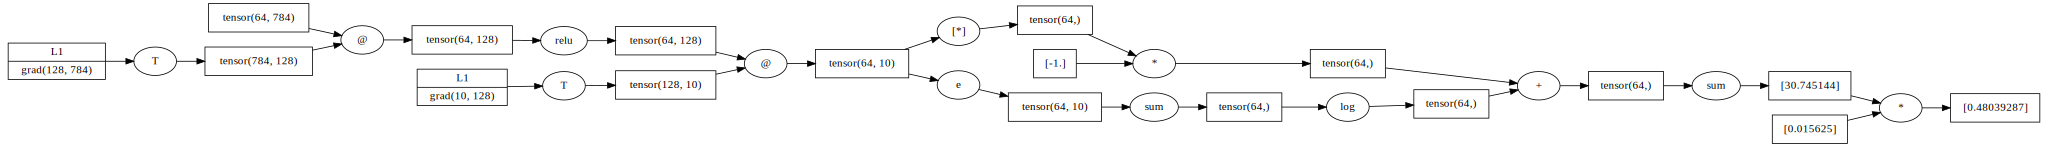

In [6]:
for i in (t := trange(epochs)):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))

    X = Tensor(X_train[samp].reshape((-1, 28*28)))
    Y = Tensor(Y_train[samp])

    out = model(X)

    cat = functional.argmax(out, axis=1)
    
    accuracy = (cat == Y).mean()

    loss = loss_fn.forward(out, Y)

    if i == 0:
        print("Initial Loss:", loss)
    
    optim.zero_grad()
    
    loss.backward()
    
    optim.step()
    
    losses.append(loss.data)
    
    accuracies.append(100*accuracy.data)
    
    t.set_description("loss %.2f accuracy %.2f" % (loss.data, 100*accuracy.data))

loss.graph


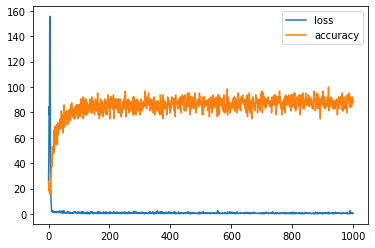

In [7]:
plt.plot(losses, label="loss")
plt.plot(accuracies, label="accuracy")
plt.legend()
plt.show()